# Inference notebook
Largely based on https://www.kaggle.com/chrisstan/darknet2pytorch-apache-license-yolov4-inference
Hoping to add elements from https://www.kaggle.com/shonenkov/bayesian-optimization-wbf-efficientdet 
Also using PL from https://www.kaggle.com/hawkey/yolov5-pseudo-labeling-oof-evaluation

When changing settings, make sure to change all resolutions (both 1024 and 1023). Also make sure the thresholds are all changed to the correct values.

In [1]:
!cp -r ../input/pytorchyolov4/tool .
#!cp ../input/yolov4weights/submit.weights .

In [2]:
import sys
sys.path.insert(0, "../input/weightedboxesfusion/")


from ensemble_boxes import *
import glob

import os
import torch
import random
import numpy as np
import pandas as pd
from glob import glob
from torch.utils.data import Dataset,DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import cv2
import gc
from tqdm import tqdm
from matplotlib import pyplot as plt

from sklearn.model_selection import StratifiedKFold
from skopt import gp_minimize, forest_minimize
from skopt.utils import use_named_args
from skopt.plots import plot_objective, plot_evaluations, plot_convergence, plot_regret
from skopt.space import Categorical, Integer, Real
from tool.utils import *
from tool.torch_utils import *
from tool.darknet2pytorch import Darknet
import argparse

In [3]:
cfgfile = '../input/yolov4weights/submit.cfg'
weightfile = '../input/yolov4weights/submit.weights' 
use_cuda = True

In [4]:
import cv2
m = Darknet(cfgfile)
m.load_weights(weightfile)
if use_cuda:
    m.cuda()
num_classes = m.num_classes
class_names = load_class_names('../input/yolov4weights/wheat.names')

convalution havn't activate linear
convalution havn't activate linear
convalution havn't activate linear


In [5]:
def get_valid_transforms():
    return A.Compose([
            A.Resize(height=704, width=704, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)

In [6]:
DATA_ROOT_PATH = '../input/global-wheat-detection/test'

class DatasetRetriever(Dataset):

    def __init__(self, image_ids, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{DATA_ROOT_PATH}/{image_id}.jpg')
        image = cv2.resize(image, (704, 704))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']
        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]
    
dataset = DatasetRetriever(
    image_ids=np.array([path.split('/')[-1][:-4] for path in glob(f'{DATA_ROOT_PATH}/*.jpg')]),
    transforms=get_valid_transforms()
)

def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=False,
    num_workers=1,
    drop_last=False,
    collate_fn=collate_fn
)

# TTA

In [7]:
class BaseWheatTTA:
    """ author: @shonenkov """
    image_size = 704

    def augment(self, image):
        raise NotImplementedError
    
    def batch_augment(self, images):
        raise NotImplementedError
    
    def deaugment_boxes(self, boxes):
        raise NotImplementedError

class TTAHorizontalFlip(BaseWheatTTA):
    """ author: @shonenkov """

    def augment(self, image):
        return image.flip(1)
    
    def batch_augment(self, images):
        return images.flip(2)
    
    def deaugment_boxes(self, boxes):
        boxes[:, [1,3]] = self.image_size - boxes[:, [3,1]]
        return boxes

class TTAVerticalFlip(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return image.flip(2)
    
    def batch_augment(self, images):
        return images.flip(3)
    
    def deaugment_boxes(self, boxes):
        boxes[:, [0,2]] = self.image_size - boxes[:, [2,0]]
        return boxes
    
class TTARotate90(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return torch.rot90(image, 1, (1, 2))

    def batch_augment(self, images):
        return torch.rot90(images, 1, (2, 3))
    
    def deaugment_boxes(self, boxes):
        res_boxes = boxes.copy()
        res_boxes[:, [0,2]] = self.image_size - boxes[:, [1,3]]
        res_boxes[:, [1,3]] = boxes[:, [2,0]]
        return res_boxes

class TTARotate180(BaseWheatTTA):
    
    def augment(self, image):
        tmp = torch.rot90(image, 1, (1, 2))
        return torch.rot90(tmp, 1, (1, 2))

    def batch_augment(self, images):
        tmp = torch.rot90(images, 1, (2, 3))
        return torch.rot90(tmp, 1, (2, 3))
    
    def deaugment_boxes(self, boxes):
        tmp = TTARotate90().deaugment_boxes(boxes)
        return TTARotate90().deaugment_boxes(tmp)
    
class TTARotate270(BaseWheatTTA):
    
    def augment(self, image):
        tmp = TTARotate180().augment(image)
        return torch.rot90(tmp, 1, (1, 2))

    def batch_augment(self, images):
        tmp = TTARotate180().batch_augment(images)
        return torch.rot90(tmp, 1, (2, 3))
    
    def deaugment_boxes(self, boxes):
        tmp = TTARotate180().deaugment_boxes(boxes)
        return TTARotate90().deaugment_boxes(tmp)
    
class TTACompose(BaseWheatTTA):
    """ author: @shonenkov """
    def __init__(self, transforms):
        self.transforms = transforms
        
    def augment(self, image):
        for transform in self.transforms:
            image = transform.augment(image)
        return image
    
    def batch_augment(self, images):
        for transform in self.transforms:
            images = transform.batch_augment(images)
        return images
    
    def prepare_boxes(self, boxes):
        result_boxes = boxes.copy()
        result_boxes[:,0] = np.min(boxes[:, [0,2]], axis=1)
        result_boxes[:,2] = np.max(boxes[:, [0,2]], axis=1)
        result_boxes[:,1] = np.min(boxes[:, [1,3]], axis=1)
        result_boxes[:,3] = np.max(boxes[:, [1,3]], axis=1)
        return result_boxes
    
    def deaugment_boxes(self, boxes):
        for transform in self.transforms[::-1]:
            boxes = transform.deaugment_boxes(boxes)
        return self.prepare_boxes(boxes)

In [8]:
def process_det(index, det, score_threshold=0.35):
    scores = det[index][:, 5].copy()
    det = det[index][:, :4].copy()
    bboxes = np.zeros((det.shape))
    bboxes[:, 0] = (det[:, 0] * 704).astype(int)
    bboxes[:, 1] = (det[:, 1] * 704).astype(int)
    bboxes[:, 2] = (det[:, 2] * 704).astype(int)
    bboxes[:, 3] = (det[:, 3] * 704).astype(int)
    bboxes = (bboxes).clip(min = 0, max = 703).astype(int)
    
    indexes = np.where(scores>score_threshold)
    bboxes = bboxes[indexes]
    scores = scores[indexes]
    return bboxes, scores

torch.Size([3, 704, 704])
-----------------------------------
           Preprocess : 0.014292
      Model Inference : 0.893512
-----------------------------------
-----------------------------------
       max and argmax : 0.001215
                  nms : 0.001585
Post processing total : 0.002800
-----------------------------------
(1, 30, 7)


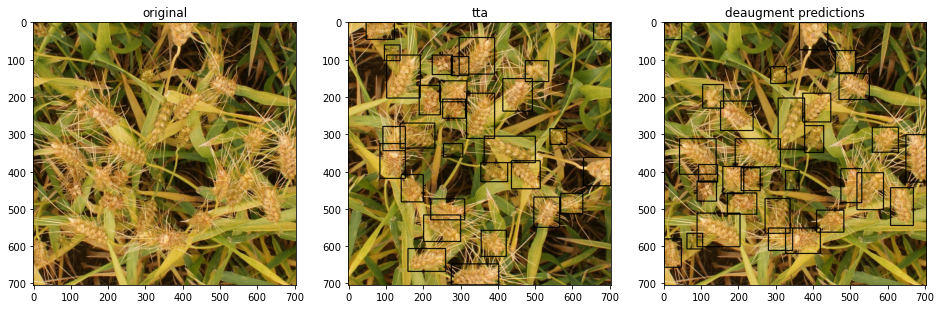

In [9]:
transform = TTACompose([
    TTARotate270(),
    #TTAVerticalFlip(),
])

fig, ax = plt.subplots(1, 3, figsize=(16, 6))

image, image_id = dataset[4] # 4 is good for fp, 3 is good for fn

numpy_image = image.permute(1,2,0).cpu().numpy().copy()

ax[0].imshow(numpy_image);
ax[0].set_title('original')

tta_image = transform.augment(image)
print(tta_image.shape)
tta_image_numpy = tta_image.permute(1,2,0).cpu().numpy().copy()

det = do_detect(m, tta_image_numpy, 0.35, 0.5, use_cuda=1)
detnp = np.array(det)
boxes, scores = process_det(0, detnp)

for box in boxes:
    cv2.rectangle(tta_image_numpy, (box[0], box[1]), (box[2],  box[3]), (0, 1, 0), 2)

print(detnp.shape)

ax[1].imshow(tta_image_numpy);
ax[1].set_title('tta')

boxes = transform.deaugment_boxes(boxes)
for box in boxes:
    cv2.rectangle(numpy_image, (box[0], box[1]), (box[2],  box[3]), (0, 1, 0), 2)

ax[2].imshow(numpy_image);
ax[2].set_title('deaugment predictions');

In [10]:
from itertools import product

tta_transforms = []
for tta_combination in product([TTAHorizontalFlip(), None], 
                               [TTAVerticalFlip(), None],
                               [TTARotate90(), None],
                               [TTARotate180(), None],
                               [TTARotate270(), None]):
    tta_transforms.append(TTACompose([tta_transform for tta_transform in tta_combination if tta_transform]))

In [11]:
def make_tta_predictions(images, score_threshold=0.35):
    with torch.no_grad():
        images = torch.stack(images).float().cuda()
        predictions = []
        #print('images.shape', images.shape)
        for tta_transform in tta_transforms:
            result = []
            input_img = tta_transform.batch_augment(images.clone()).permute(0,2,3,1).cpu().numpy()
            #print('input_img',input_img.shape)
            det = do_detect(m, input_img, 0.35, 0.5, use_cuda=1)
            #print([len(i) for i in det])
            det = [np.array(i)for i in det]
            #print(det)
            for i in range(images.shape[0]):
                boxes, scores = process_det(i, det)
                boxes = tta_transform.deaugment_boxes(boxes.copy())
                result.append({
                    'boxes': boxes,
                    'scores': scores,
                })
            predictions.append(result)
    return predictions

import ensemble_boxes 

def run_wbf(predictions, image_index, image_size=704, iou_thr=0.34, skip_box_thr=0.31, weights=None):
    boxes = [(prediction[image_index]['boxes']/(image_size-1)).tolist() for prediction in predictions]
    scores = [prediction[image_index]['scores'].tolist() for prediction in predictions]
    labels = [np.ones(prediction[image_index]['scores'].shape[0]).astype(int).tolist() for prediction in predictions]
    boxes, scores, labels = ensemble_boxes.ensemble_boxes_wbf.weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes = boxes*(image_size-1)
    return boxes, scores, labels

-----------------------------------
           Preprocess : 0.009271
      Model Inference : 0.079395
-----------------------------------
-----------------------------------
       max and argmax : 0.001778
                  nms : 0.002695
Post processing total : 0.004473
-----------------------------------
-----------------------------------
           Preprocess : 0.009577
      Model Inference : 0.075354
-----------------------------------
-----------------------------------
       max and argmax : 0.001080
                  nms : 0.002614
Post processing total : 0.003694
-----------------------------------
-----------------------------------
           Preprocess : 0.009543
      Model Inference : 0.072747
-----------------------------------
-----------------------------------
       max and argmax : 0.002115
                  nms : 0.002475
Post processing total : 0.004591
-----------------------------------
-----------------------------------
           Preprocess : 0.004989
    

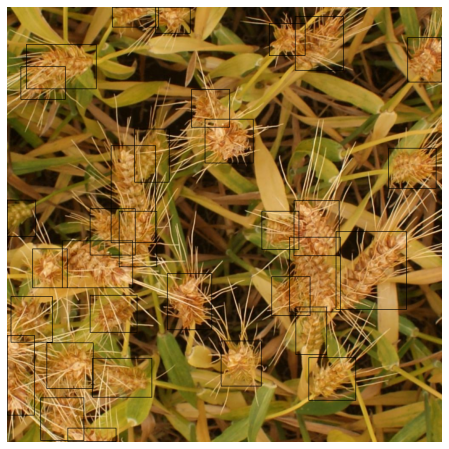

In [12]:
import matplotlib.pyplot as plt
for j, (images, image_ids) in enumerate(data_loader):
    break

predictions = make_tta_predictions(images)

i = 1
sample = images[i].permute(1,2,0).cpu().numpy()
boxes, scores, labels = run_wbf(predictions, image_index=i)
boxes = boxes.round().astype(np.int32).clip(min=0, max=703)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (1, 0, 0), 1)

ax.set_axis_off()
ax.imshow(sample);

In [13]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))
    return " ".join(pred_strings)

In [14]:
results = []

for images, image_ids in data_loader:
    try:
        predictions = make_tta_predictions(images)
    
        for i, image in enumerate(images):
            
            boxes, scores, labels = run_wbf(predictions, image_index=i)
            boxes = (boxes*(1024 / 704)).round().astype(np.int32).clip(min=0, max=1023)
            image_id = image_ids[i]

            boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
            if len(boxes) > 0:
                result = {
                    'image_id': image_id,
                    'PredictionString': format_prediction_string(boxes, scores)
                }
                results.append(result)
    except:
        for i, image in enumerate(images):
            image_id = image_ids[i]
            result = {
                'image_id': image_id,
                'PredictionString': ''
            }
            results.append(result)
        

-----------------------------------
           Preprocess : 0.015856
      Model Inference : 0.072981
-----------------------------------
-----------------------------------
       max and argmax : 0.001724
                  nms : 0.003267
Post processing total : 0.004992
-----------------------------------
-----------------------------------
           Preprocess : 0.011007
      Model Inference : 0.072813
-----------------------------------
-----------------------------------
       max and argmax : 0.001051
                  nms : 0.002728
Post processing total : 0.003778
-----------------------------------
-----------------------------------
           Preprocess : 0.004575
      Model Inference : 0.072387
-----------------------------------
-----------------------------------
       max and argmax : 0.001193
                  nms : 0.002617
Post processing total : 0.003810
-----------------------------------
-----------------------------------
           Preprocess : 0.005828
    

In [15]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.to_csv('submission.csv', index=False)
test_df

,image_id,PredictionString
0,cc3532ff6,0.9886 766 825 175 172 0.9733 488 573 102 140 ...
1,796707dd7,0.9497 897 331 113 95 0.9349 710 825 110 100 0...
2,53f253011,0.9804 20 597 123 143 0.9780 293 444 189 85 0....
3,51f1be19e,0.9438 801 760 113 101 0.9361 272 468 149 131 ...
4,f5a1f0358,0.9715 943 432 80 190 0.9603 133 749 168 121 0...
5,2fd875eaa,0.9950 466 351 124 99 0.9940 107 585 137 82 0....
6,51b3e36ab,0.9505 461 10 87 148 0.9465 1 912 82 111 0.944...
7,348a992bb,0.9820 734 222 143 90 0.9641 1 318 120 95 0.96...
8,cb8d261a3,0.9698 17 559 188 105 0.9666 23 863 78 150 0.9...
9,aac893a91,0.9886 25 451 108 161 0.9856 565 533 116 189 0...
